##Prediksi Harga Minyak Per-Minggu

Data yang digunakan merupakan data harga penjualan minyak goreng per minggu, dimulai dari tahun 2020-2024
Data diambil dari situs https://www.bi.go.id/hargapangan/TabelHarga/PasarTradisionalDaerah

#Read Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#Mengambil dan menampilkan data
df = pd.read_excel('/content/drive/MyDrive/PSD/DataMinyak/OilPrice/harga_minyak.xlsx')
df

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000002CADB6C9CC0>>
Traceback (most recent call last):
  File "C:\laragon\bin\python\python-3.10\lib\site-packages\ipykernel\ipkernel.py", line 788, in _clean_thread_parent_frames


    if phase != "start":
KeyboardInterrupt: 


ModuleNotFoundError: No module named 'plotly'

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# Pastikan kolom 'Date' dalam format datetime dengan dayfirst=True
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, errors='coerce')

# Mengatur kolom 'Date' sebagai indeks
df.set_index('Tanggal', inplace=True)

# Menghapus spasi dari kolom 'Harga', mengganti '-' dengan NaN, dan mengubahnya menjadi numeric
df['Harga'] = df['Harga'].replace('-', np.nan).str.replace(',', '').astype(float)

# Menampilkan 5 baris pertama untuk memastikan
print(df.head())

              Harga
Tanggal            
2020-01-01  15550.0
2020-01-08  15500.0
2020-01-15  15550.0
2020-01-22  15600.0
2020-01-29  15650.0


#Menjelaskan Data

<Axes: xlabel='Tanggal'>

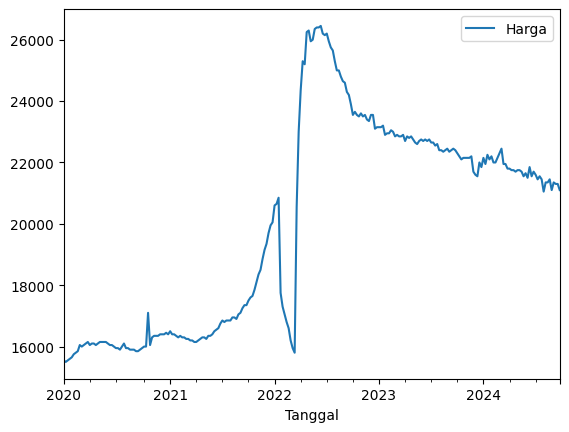

In [61]:
df.plot()

In [62]:
df.info()
print('Ukuran data ', df.shape)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248 entries, 2020-01-01 to 2024-09-25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Harga   248 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
Ukuran data  (248, 1)


In [63]:
df.dtypes

,0
Harga,float64


In [64]:
# Mencari Missing Value
df.isnull().sum()

,0
Harga,0


In [65]:
# Deskripsi Statistik
df.describe()

,Harga
count,248.000000
mean,20019.153226
std,3397.558973
min,15500.000000
25%,16350.000000
50%,21350.000000
75%,22700.000000
max,26450.000000


#Sliding Windows

In [76]:
def create_lag_features(df, column_name, num_lags):

    # Buat fitur lag untuk jumlah lag yang diinginkan
    for lag in range(1, num_lags + 1):
        df[f'{column_name}-{lag}'] = df[column_name].shift(lag)

    # Hapus baris yang memiliki nilai NaN setelah pembuatan lag
    df.dropna(inplace=True)

    # Mengatur ulang kolom sehingga kolom asli berada di posisi terakhir
    lag_columns = [f'{column_name}-{lag}' for lag in range(num_lags, 0, -1)] + [column_name]
    df = df[lag_columns]

    return df

# Contoh penggunaan
num_lags = 4  # Tentukan berapa banyak lag yang diinginkan
df_lagged = create_lag_features(df, 'Harga', num_lags)

# Menampilkan 5 baris pertama untuk memastikan fitur lag telah ditambahkan
df_lagged.head()


,Harga-4,Harga-3,Harga-2,Harga-1,Harga
4,15550.0,15500.0,15550.0,15600.0,15650.0
5,15500.0,15550.0,15600.0,15650.0,15750.0
6,15550.0,15600.0,15650.0,15750.0,15800.0
7,15600.0,15650.0,15750.0,15800.0,15850.0
8,15650.0,15750.0,15800.0,15850.0,16050.0


#Normalisasi Data

In [77]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Fungsi untuk membuat fitur lag secara dinamis
def create_lag_features(df, column_name, num_lags):

    # Buat fitur lag untuk jumlah lag yang diinginkan
    for lag in range(1, num_lags + 1):
        df[f'{column_name}-{lag}'] = df[column_name].shift(lag)

    # Hapus baris yang memiliki nilai NaN setelah pembuatan lag
    df.dropna(inplace=True)

    # Mengatur ulang kolom sehingga kolom asli berada di posisi terakhir
    lag_columns = [f'{column_name}-{lag}' for lag in range(num_lags, 0, -1)] + [column_name]
    df = df[lag_columns]

    return df

# Tentukan jumlah lag
num_lags = 4

# Membuat fitur lag dinamis
df_lagged = create_lag_features(df, 'Harga', num_lags)

# Inisialisasi scaler untuk fitur (input) dan target (output)
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Normalisasi fitur (Harga-1, Harga-2, ..., Harga-n)
df_features_normalized = pd.DataFrame(scaler_features.fit_transform(df_lagged.iloc[:, :-1]),
                                      columns=df_lagged.columns[:-1],
                                      index=df_lagged.index)

# Normalisasi target (Harga)
df_target_normalized = pd.DataFrame(scaler_target.fit_transform(df_lagged[['Harga']]),
                                    columns=['Harga'],
                                    index=df_lagged.index)

# Gabungkan kembali dataframe yang sudah dinormalisasi
df_normalized = pd.concat([df_features_normalized, df_target_normalized], axis=1)

# Tampilkan 5 baris pertama dari dataframe yang sudah dinormalisasi
df_normalized.head()


,Harga-4,Harga-3,Harga-2,Harga-1,Harga
8,0.000000,0.000000,0.000000,0.004695,0.023474
9,0.009259,0.004673,0.004695,0.023474,0.018779
10,0.013889,0.009346,0.023474,0.018779,0.023474
11,0.018519,0.028037,0.018779,0.023474,0.028169
12,0.037037,0.023364,0.023474,0.028169,0.032864


===== Data Train =====
      Harga-1   Harga-2   Harga-3   Harga-4
12   0.028169  0.023474  0.018779  0.023474
13   0.032864  0.028169  0.023474  0.018779
14   0.023474  0.032864  0.028169  0.023474
15   0.028169  0.023474  0.032864  0.028169
16   0.028169  0.028169  0.023474  0.032864
..        ...       ...       ...       ...
195  0.624413  0.619718  0.615023  0.624413
196  0.619718  0.624413  0.619718  0.615023
197  0.610329  0.619718  0.624413  0.619718
198  0.600939  0.610329  0.619718  0.624413
199  0.591549  0.600939  0.610329  0.619718

[188 rows x 4 columns]
===== Data Testing =====
      Harga-1   Harga-2   Harga-3   Harga-4
200  0.596244  0.591549  0.600939  0.610329
201  0.596244  0.596244  0.591549  0.600939
202  0.596244  0.596244  0.596244  0.591549
203  0.596244  0.596244  0.596244  0.596244
204  0.600939  0.596244  0.596244  0.596244
205  0.553991  0.600939  0.596244  0.596244
206  0.544601  0.553991  0.600939  0.596244
207  0.539906  0.544601  0.553991  0.600939
208 

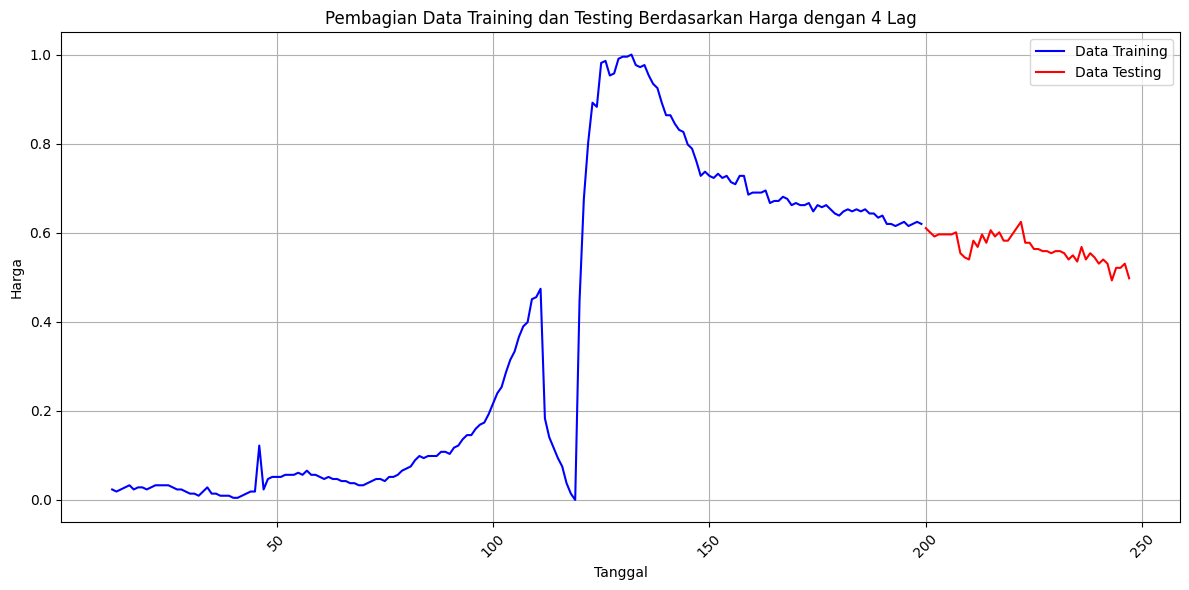

In [78]:
# Definisikan jumlah lag dinamis
num_lags = 4 

# Membuat kolom lag secara dinamis
for i in range(1, num_lags + 1):
    df_normalized[f'Harga-{i}'] = df_normalized['Harga'].shift(i)

# Menghapus baris yang memiliki nilai NaN akibat lag
df_normalized = df_normalized.dropna()

# Mengatur fitur (X) dan target (y)
lag_columns = [f'Harga-{i}' for i in range(1, num_lags + 1)]
X = df_normalized[lag_columns]
y = df_normalized['Harga']

# Membagi data menjadi training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print('===== Data Train =====')
print(X_train)

print('===== Data Testing =====')
print(X_test)

# Mengambil nilai tanggal dari indeks X_train dan X_test
dates_train = X_train.index
dates_test = X_test.index

# Plot data training dan testing
plt.figure(figsize=(12, 6))
plt.plot(dates_train, X_train[f'Harga-{num_lags}'], label='Data Training', color='blue')
plt.plot(dates_test, X_test[f'Harga-{num_lags}'], label='Data Testing', color='red')

# Menambahkan judul, label, dan legenda
plt.title(f'Pembagian Data Training dan Testing Berdasarkan Harga dengan {num_lags} Lag')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


##JST (Jaringan Syaraf Tiruan atau ANN)

In [79]:
# Membuat fitur lag dinamis
lags = [4]
for lag in lags:
    df[f'Harga-{lag}'] = df['Harga'].shift(lag)

# Menghapus baris dengan NaN setelah membuat lag
df.dropna(inplace=True)

# Memilih kolom lag yang ingin digunakan
lag_columns = [f'Harga-{lag}' for lag in lags]
df_lag = df[lag_columns + ['Harga']]


normalisasi fitur lag

In [70]:
# Normalisasi fitur lag dan target
df_features_normalized = pd.DataFrame(scaler_features.fit_transform(df_lag[lag_columns]),
                                      columns=lag_columns,
                                      index=df_lag.index)

df_target_normalized = pd.DataFrame(scaler_target.fit_transform(df_lag[['Harga']]),
                                    columns=['Harga'],
                                    index=df_lag.index)

# Gabungkan kembali fitur lag dan target yang sudah dinormalisasi
df_normalized = pd.concat([df_features_normalized, df_target_normalized], axis=1)


mengatur data uji dan data latih

In [16]:
# Mengatur fitur (X) dan target (y)
X = df_normalized[lag_columns]
y = df_normalized['Harga']

# Membagi data menjadi training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [80]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

# Membaca data dan mengonversi kolom 'Harga' ke format numerik
df = pd.read_excel('/content/drive/MyDrive/PSD/DataMinyak/OilPrice/harga_minyak.xlsx')
df['Harga'] = df['Harga'].replace(',', '', regex=True).astype(float)  # Menghapus koma dan mengonversi ke float

# Fungsi untuk membuat fitur lag dinamis
def create_lagged_features(data, target_column, lag_list):
    df = data.copy()
    for lag in lag_list:
        df[f'{target_column}-{lag}'] = df[target_column].shift(lag)
    df.dropna(inplace=True)  # Menghapus baris dengan NaN setelah membuat lag
    return df

# Menentukan lag yang diinginkan 
lag_list = [4]
df_lag = create_lagged_features(df, 'Harga', lag_list)

# Normalisasi fitur lag dan target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Normalisasi hanya kolom yang dipilih (Harga-4)
lag_column_name = [f'Harga-{lag}' for lag in lag_list]  # Kolom yang relevan
df_features_normalized = pd.DataFrame(scaler_features.fit_transform(df_lag[lag_column_name]), columns=lag_column_name, index=df_lag.index)
df_target_normalized = pd.DataFrame(scaler_target.fit_transform(df_lag[['Harga']]), columns=['Harga'], index=df_lag.index)

# Menggabungkan fitur lag dan target yang sudah dinormalisasi
df_normalized = pd.concat([df_features_normalized, df_target_normalized], axis=1)

# Mengatur fitur (X) dan target (y)
X = df_normalized[lag_column_name]  
y = df_normalized['Harga']

# Membagi data menjadi training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Membangun model Neural Network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='linear'))  # Output layer

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
print(f'Loss pada data uji (MSE): {loss}')

# Membuat prediksi menggunakan data uji
y_pred = model.predict(X_test)

# Mengembalikan hasil prediksi ke skala asli
y_pred_original = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.values.reshape(-1, 1))

# Metrik evaluasi
mae = mean_absolute_error(y_test_original, y_pred_original)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test_original, y_pred_original)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(y_test_original, y_pred_original)
print(f'R-squared (R²): {r2}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0676 - val_loss: 0.0144
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0271 - val_loss: 0.0024
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0190 - val_loss: 0.0054
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0187 - val_loss: 9.3774e-04
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0132 - val_loss: 0.0013
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0127 - val_loss: 0.0014
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0163 - val_loss: 5.3550e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0142 - val_loss: 5.1356e-04
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 5.5055e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - val_loss: 5.3499e-04
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - val_loss: 5.1735e-04
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0134 - val_loss: 5.

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.2412 - val_loss: 0.2126
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1572 - val_loss: 0.1282
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1132 - val_loss: 0.0728
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0669 - val_loss: 0.0334
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0438 - val_loss: 0.0106
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0360 - val_loss: 0.0012
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0259 - val_loss: 6.7532e-04
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0259 - val_loss: 0.0011
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0240 - val_loss: 6.0389e-04
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0215 - val_loss: 6.3706e-04
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0201 - val_loss: 8.8534e-04
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0204 - val_loss: 7.4

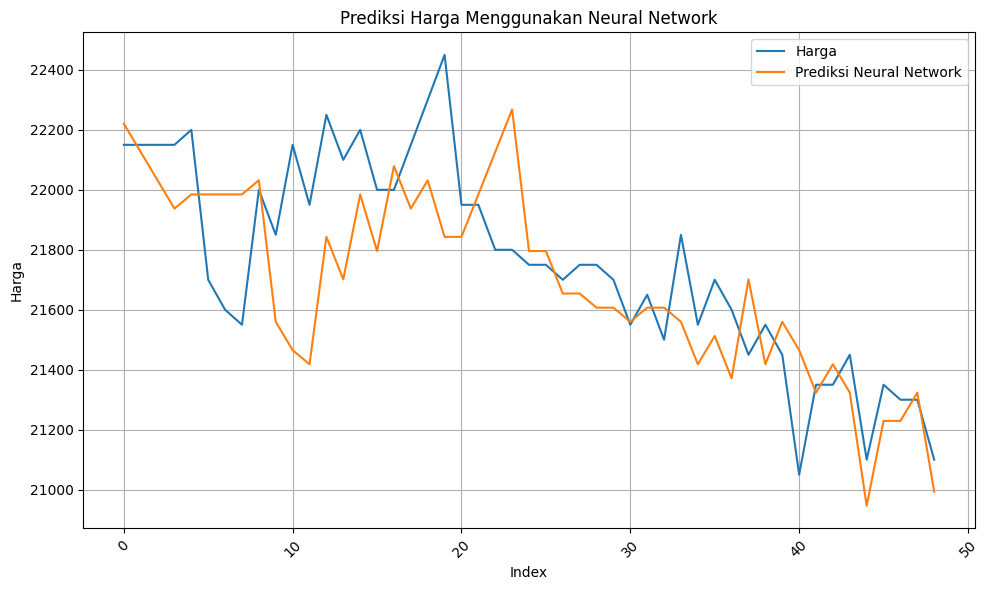

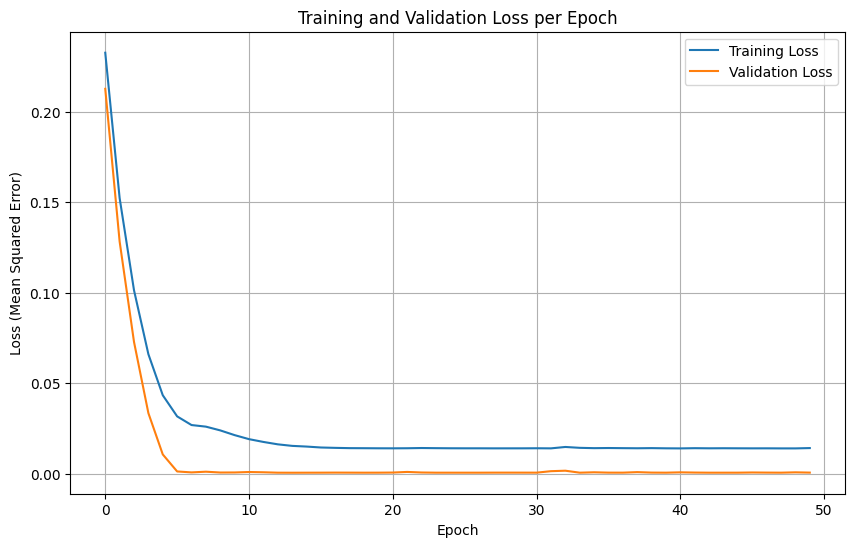

In [81]:
tf.keras.backend.clear_session()

# Membuat model Neural Network
model = Sequential()

# Input layer (sesuai dengan jumlah fitur) dan hidden layer pertama
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Hidden layer kedua
model.add(Dense(32, activation='relu'))

# Output layer (1 neuron untuk prediksi nilai Harga)
model.add(Dense(1, activation='linear'))

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Melatih model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
print(f'Loss pada data uji (MSE): {loss}')

# Membuat prediksi menggunakan data uji
y_pred = model.predict(X_test)

# Mengembalikan hasil prediksi ke skala asli (dari skala normalisasi)
y_pred_original = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.values.reshape(-1, 1))


# Plot hasil prediksi vs nilai sebenarnya dengan sumbu x sebagai tanggal
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Harga')
plt.plot(y_pred_original, label='Prediksi Neural Network')
plt.title('Prediksi Harga Menggunakan Neural Network')
plt.xlabel('Index')
plt.ylabel('Harga')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotasi label x-axis agar lebih mudah dibaca
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Plot error (loss) selama training dan validasi tiap epoch
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

In [82]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Membuat prediksi menggunakan data uji
y_pred = model.predict(X_test)

# Hitung Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Hitung Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Menghitung RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Hitung R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

# Hitung Mean Absolute Percentage Error (MAPE)
# mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean Absolute Error (MAE): 0.018295435430601713
Mean Squared Error (MSE): 0.0005592822745049739
Root Mean Squared Error (RMSE): 0.023649149551410384
R-squared (R²): 0.43291644648688565
Mean Absolute Percentage Error (MAPE): 0.03200665647291713%


##JST + Ensemble Bagging

In [20]:
pip install scikeras[tensorflow]

Skor pada data uji: 0.6555400608758065


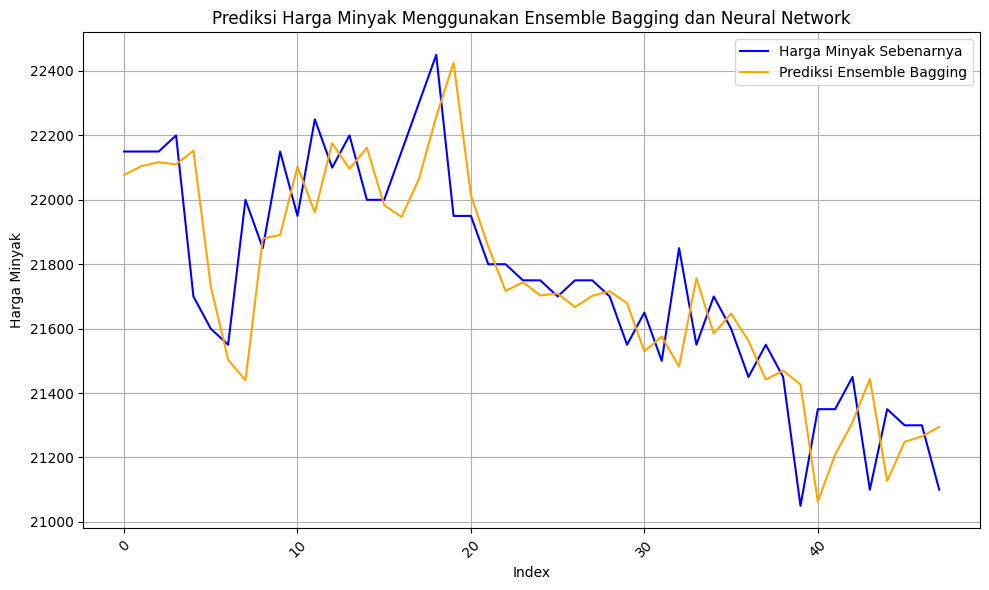

In [83]:
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import BaggingRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

tf.keras.backend.clear_session()

# Definisikan jumlah lag dinamis
num_lags = 4  

# Membuat kolom lag secara dinamis
for i in range(1, num_lags + 1):
    df_normalized[f'Harga-{i}'] = df_normalized['Harga'].shift(i)

# Menghapus baris yang memiliki nilai NaN akibat lag
df_normalized = df_normalized.dropna()

# Mengatur fitur (X) dan target (y)
lag_columns = [f'Harga-{i}' for i in range(1, num_lags + 1)]
X = df_normalized[lag_columns]
y = df_normalized['Harga']

# Membagi data menjadi training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fungsi untuk membuat model neural network
def create_model():
    model = Sequential()
    model.add(Input(shape=(num_lags,)))  # Menggunakan num_lags sebagai input
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Membuat KerasRegressor dari model yang sudah dibuat
neural_network = KerasRegressor(model=create_model, epochs=50, batch_size=32, verbose=0)

# Membuat model Bagging Regressor dengan estimator neural network
bagging_model = BaggingRegressor(estimator=neural_network, n_estimators=10, random_state=24)

# Melatih model
bagging_model.fit(X_train, y_train)

# Evaluasi model pada data uji
loss = bagging_model.score(X_test, y_test)
print(f'Skor pada data uji: {loss}')

# Membuat prediksi menggunakan data uji
y_pred = bagging_model.predict(X_test)

# Mengembalikan hasil prediksi ke skala asli (dari skala normalisasi)
y_pred_original = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_target.inverse_transform(y_test.values.reshape(-1, 1))

# Plot hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Harga Minyak Sebenarnya', color='blue')
plt.plot(y_pred_original, label='Prediksi Ensemble Bagging', color='orange')
plt.title('Prediksi Harga Minyak Menggunakan Ensemble Bagging dan Neural Network')
plt.xlabel('Index')
plt.ylabel('Harga Minyak')
plt.xticks(rotation=45)  # Memutar label x untuk keterbacaan
plt.legend()
plt.grid(True)
plt.tight_layout()  # Menyesuaikan layout agar tidak terpotong
plt.show()


In [84]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# Membuat prediksi menggunakan data uji
y_pred = bagging_model.predict(X_test)

# Hitung Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Hitung Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Menghitung RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Hitung R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2}')

# Hitung Mean Absolute Percentage Error (MAPE)
# mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Mean Absolute Error (MAE): 0.013764557785090129
Mean Squared Error (MSE): 0.00033715571887870527
Root Mean Squared Error (RMSE): 0.01836180053477069
R-squared (R²): 0.6555400608758065
Mean Absolute Percentage Error (MAPE): 0.024493333609521783%


##Grid Search

Skenario akan dilakukan dengan percobaan menggunakan skenario hyperparameter
```
epochs        = [20, 50]
batch_sizes   = [32, 42]
random_states = [24, 42]
n_estimators  = [5, 10]
```
Total percobaan = 16

    Epochs  Batch Size  Random State  N Estimators        R²       MSE  \
0       20          32            24             5  0.698464  0.000304   
1       20          32            24            10  0.685795  0.000316   
2       20          32            42             5  0.636097  0.000366   
3       20          32            42            10  0.662861  0.000339   
4       20          42            24             5  0.689446  0.000313   
5       20          42            24            10  0.592514  0.000410   
6       20          42            42             5  0.599739  0.000403   
7       20          42            42            10  0.592580  0.000410   
8       50          32            24             5  0.694640  0.000307   
9       50          32            24            10  0.671136  0.000331   
10      50          32            42             5  0.660320  0.000342   
11      50          32            42            10  0.668899  0.000333   
12      50          42            24  

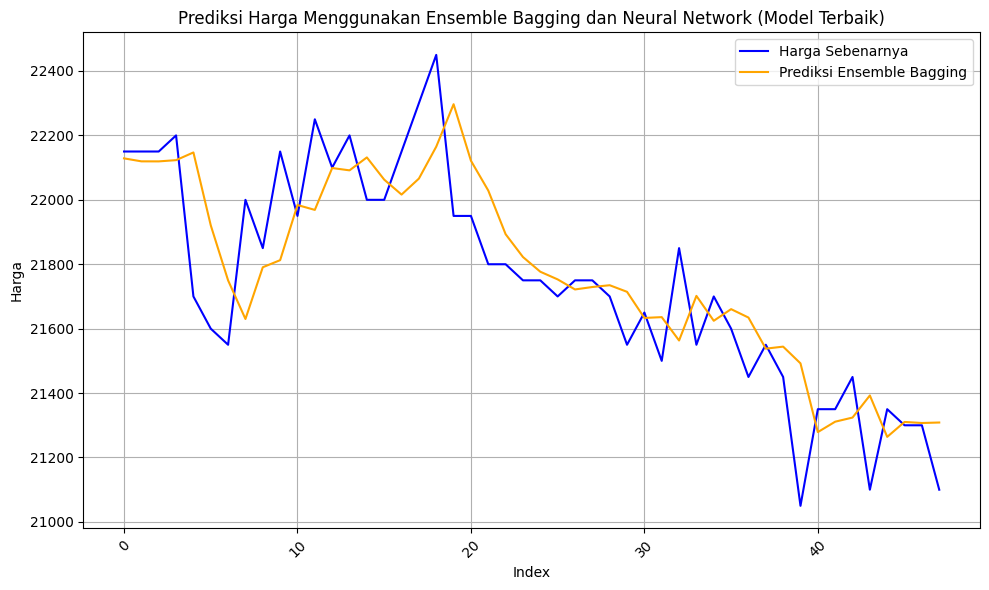

In [74]:
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

tf.keras.backend.clear_session()

# Definisikan jumlah lag dinamis
num_lags = 4  

# Membuat kolom lag secara dinamis
for i in range(1, num_lags + 1):
    df_normalized[f'Harga-{i}'] = df_normalized['Harga'].shift(i)

# Menghapus baris yang memiliki nilai NaN akibat lag
df_normalized = df_normalized.dropna()

# Mengatur fitur (X) dan target (y)
lag_columns = [f'Harga-{i}' for i in range(1, num_lags + 1)]
X = df_normalized[lag_columns]
y = df_normalized['Harga']

# Fungsi untuk membuat model neural network
def create_model():
    model = Sequential()
    model.add(Input(shape=(num_lags,)))  # Menggunakan num_lags sebagai input
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Daftar parameter untuk percobaan
epochs_list = [20, 50]
batch_sizes = [32, 42]
random_states = [24, 42]
n_estimators_list = [5, 10]

# Menyimpan hasil
results = []
best_model = None
best_rmse = float('inf')
best_params = None

# Melakukan iterasi melalui semua kombinasi hyperparameter
for epochs in epochs_list:
    for batch_size in batch_sizes:
        for random_state in random_states:
            for n_estimators in n_estimators_list:

                # Membuat KerasRegressor dari model yang sudah dibuat
                neural_network = KerasRegressor(model=create_model,
                                                 epochs=epochs,
                                                 batch_size=batch_size,
                                                 verbose=0)

                # Membuat model Bagging Regressor dengan estimator neural network
                bagging_model = BaggingRegressor(estimator=neural_network, n_estimators=n_estimators, random_state=random_state)

                # Membagi data menjadi training dan testing (80% training, 20% testing)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

                # Melatih model
                bagging_model.fit(X_train, y_train)

                # Melakukan prediksi menggunakan data uji
                y_pred = bagging_model.predict(X_test)

                # Menghitung metrik evaluasi
                r2 = r2_score(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)

                # Menyimpan hasil
                results.append({
                    'Epochs': epochs,
                    'Batch Size': batch_size,
                    'Random State': random_state,
                    'N Estimators': n_estimators,
                    'R²': r2,
                    'MSE': mse,
                    'RMSE': rmse
                })

                # Menyimpan model terbaik
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = bagging_model
                    best_params = (epochs, batch_size, random_state, n_estimators)

# Membuat DataFrame dari hasil
results_df = pd.DataFrame(results)

# Menampilkan hasil
print(results_df)

# Menampilkan model terbaik dan parameter terbaik
print("Model terbaik dengan RMSE:", best_rmse)
print("Parameter model terbaik:", best_params)

# Menggunakan model terbaik untuk memprediksi
y_best_pred = best_model.predict(X_test)

# Plot hasil prediksi vs nilai sebenarnya untuk model terbaik
plt.figure(figsize=(10, 6))
plt.plot(scaler_target.inverse_transform(y_test.values.reshape(-1, 1)), label='Harga Sebenarnya', color='blue')
plt.plot(scaler_target.inverse_transform(y_best_pred.reshape(-1, 1)), label='Prediksi Ensemble Bagging', color='orange')
plt.title('Prediksi Harga Menggunakan Ensemble Bagging dan Neural Network (Model Terbaik)')
plt.xlabel('Index')
plt.ylabel('Harga')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Uji Coba

In [88]:
import numpy as np

# Fungsi untuk memprediksi kurs berdasarkan input dari pengguna
def predict_custom_data(input_data):

    # Reshape input to (1, 1) for scaling
    input_data_reshaped = np.array(input_data).reshape(-1, 1)

    # Normalize data input using scaler_features
    input_data_normalized = scaler_features.transform(input_data_reshaped)

    # Reshape the scaled data to match the model's input shape (1, num_lags)
    input_data_normalized = input_data_normalized.reshape(1, -1)

    # Prediksi dengan model Bagging Regressor
    predicted_normalized = bagging_model.predict(input_data_normalized)

    # Mengembalikan prediksi ke skala asli
    predicted_original = scaler_target.inverse_transform(predicted_normalized.reshape(-1, 1))

    return predicted_original[0, 0]

# Meminta input dari pengguna
print("Masukkan harga minyak dari minggu-minggu sebelumnya:")
harga_1 = float(input("Harga 1 hari sebelumnya : "))
harga_2 = float(input("Harga 2 hari sebelumnya : "))
harga_3 = float(input("Harga 3 hari sebelumnya : "))
harga_4 = float(input("Harga 4 hari sebelumnya : "))

# Data input yang dimasukkan oleh pengguna
user_input = [harga_1, harga_2, harga_3, harga_4]

# Prediksi harga minyak untuk data yang dimasukkan
predicted_value = predict_custom_data(user_input)

# Menampilkan hasil prediksi
print(f"Prediksi harga minyak untuk minggu selanjutnya adalah: {predicted_value:.2f}")


Masukkan harga minyak dari minggu-minggu sebelumnya:
Harga 1 hari sebelumnya : 15600
Harga 2 hari sebelumnya : 15550
Harga 3 hari sebelumnya : 15500
Harga 4 hari sebelumnya : 15550


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


Prediksi harga minyak untuk minggu selanjutnya adalah: 15960.75


##Perbandingan Metode

In [93]:
#Mengambil dan menampilkan data
df = pd.read_csv('/content/drive/MyDrive/PSD/Perbandingan_Metode/perbandingan_metode2.csv')
df

,Model,lag-4,lag-5,lag-6,lag-7
0,model-1 (JST),0.03%,0.06%,0.05%,0.04%
1,model-2(SVM),1318012082465950.00%,1247217424504390.00%,1104240897551030.00%,1167438802916020.00%
2,model-3(Regresi Random Forest),5.82%,5.63%,5.37%,5.37%
3,model-4(Logistic Regresi),1195322103805420.00%,1181844009382110.00%,1161121599742140.00%,1140179286661270.00%
4,NaN,NaN,NaN,NaN,NaN
